<a href="https://colab.research.google.com/github/Elixirman/my_HYE_Works/blob/main/Time_Series_Snippet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Quiz

# About

In this quiz, we’ll explore and build time series forecasting models for measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

Data Set Information:

Data Link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:

1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

date: Date in format dd/mm/yyyy
time: time in format hh:mm:ss
globalactivepower: household global minute-averaged active power (in kilowatt)
globalreactivepower: household global minute-averaged reactive power (in kilowatt)
voltage: minute-averaged voltage (in volt)
global_intensity: household global minute-averaged current intensity (in ampere)
submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# Dependencies

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.interpolate import UnivariateSpline
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
warnings.filterwarnings('ignore')

# Data Importation

In [100]:
# Import Data head
df = pd.read_csv("https://archive.ics.uci.edu/static/public/235/data.csv")

In [101]:
# Load the datasets from the mounted Google Drive
dfx = pd.read_csv("/content/drive/My Drive/Time-Series/Individual Household Electric Power Consumption.csv")

# Data Head

In [102]:
dfx.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [103]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# df to CSV
#df.to_csv('Individual Household Electric Power Consumption.csv', index=False)

# SID-Analysis

## Shape

In [104]:
df.shape

(2075259, 9)

## Info

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## De-Stats

In [ ]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


# Data Preprocessig

## Quest 11 -

## Object 2 Numeric

In [106]:
# Convert columns to numeric
for column in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [107]:
# Preview Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


## Sub_metering_4

(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3)

In [108]:
# New Column Creation to 2dp
df['Sub_metering_4'] = ((df['Global_active_power'] * 1000 / 60) - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']).round(2)

## Object 2 Date-Time

In [109]:
df["Date"] = df["Date"].astype(str)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

In [110]:
df["Time"] = df["Time"].astype(str)
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S")

In [111]:
#Preview Date Column Type
df["Date"].dtype

dtype('<M8[ns]')

In [112]:
# Preview Time column Type
df["Time"].dtype

dtype('<M8[ns]')

In [113]:
df.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
0,2006-12-16,1900-01-01 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.27
1,2006-12-16,1900-01-01 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.33


In [114]:
# Preview Shape
df.shape

(2075259, 10)

## Visualize Data

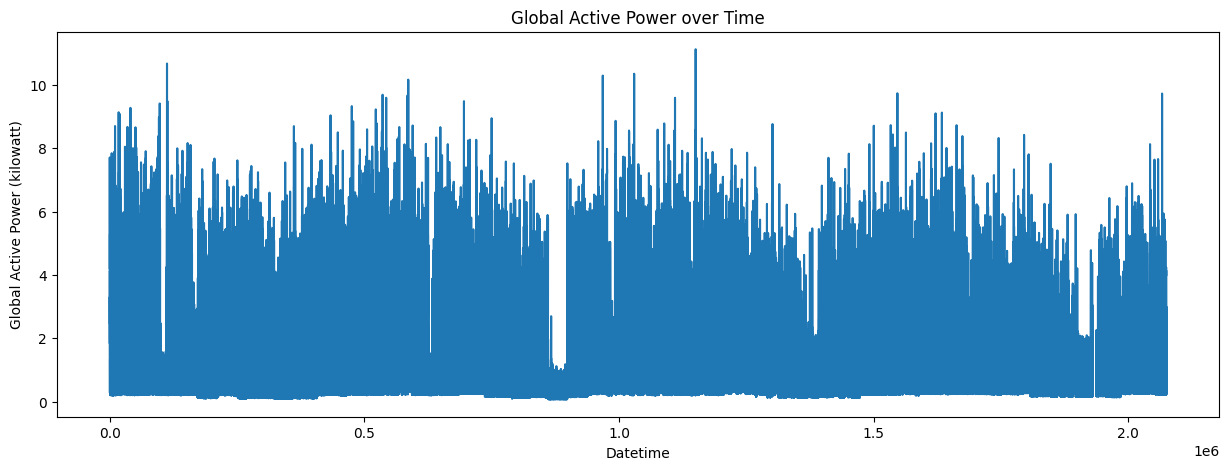

In [115]:
# Plot Global Active Power over time
plt.figure(figsize=(15, 5))
plt.plot(df['Global_active_power'])
plt.title('Global Active Power over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatt)')
plt.show()


## Missing Data

In [116]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

### % of Missing Data

In [117]:
# Percentage of missing data to 2dp
missing_data_percentage = (df.isnull().sum() / len(df)) * 100

#Add percentage symbol to every output
for column, missing_count in missing_data_percentage.items():
  print(f"{column}: {missing_count:.2f}%")


Date: 0.00%
Time: 0.00%
Global_active_power: 1.25%
Global_reactive_power: 1.25%
Voltage: 1.25%
Global_intensity: 1.25%
Sub_metering_1: 1.25%
Sub_metering_2: 1.25%
Sub_metering_3: 1.25%
Sub_metering_4: 1.25%


### Missing Data Visual

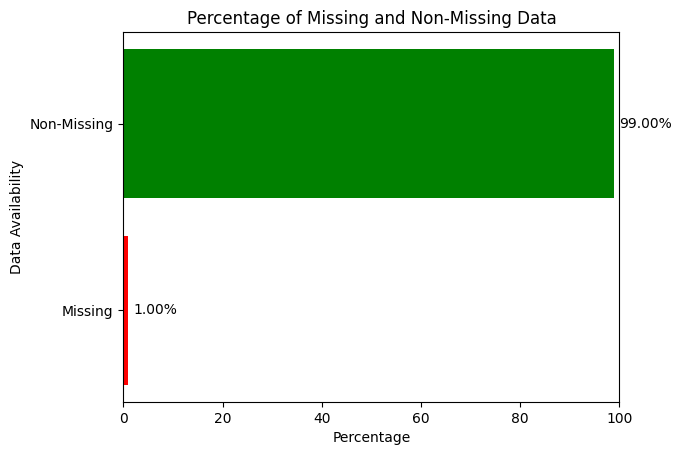

In [118]:
# Calculate the total number of missing values
total_missing = df.isnull().sum().sum()

# Calculate the total number of values in the dataset
total_values = df.size

# Calculate the total number of non-missing values
total_non_missing = total_values - total_missing

# Calculate the percentage of missing and non-missing data
percentage_missing = (total_missing / total_values) * 100
percentage_non_missing = 100 - percentage_missing

# Plot the horizontal bar graph
categories = ['Missing', 'Non-Missing']
percentages = [percentage_missing, percentage_non_missing]

plt.barh(categories, percentages, color=['red', 'green'])
plt.ylabel('Data Availability')
plt.xlabel('Percentage')
plt.title('Percentage of Missing and Non-Missing Data')

# Annotate the percentage values on the bars
for i, percentage in enumerate(percentages):
    plt.text(percentage + 1, i, f'{percentage:.2f}%', va='center', ha='left')

plt.xlim(0, 100)  # Set x-axis limit to 0-100%
plt.show()

### Outlier Verification

Use Median When:

Your data has significant outliers or is skewed.

You need a simple and robust method to fill missing values.

The missing values do not have a strong local dependency.

Use Rolling Mean When:

Your data is a time series or has a sequential structure.

You believe that the missing values are better estimated by considering nearby values.

Your dataset does not have significant outliers or you have handled them separately.

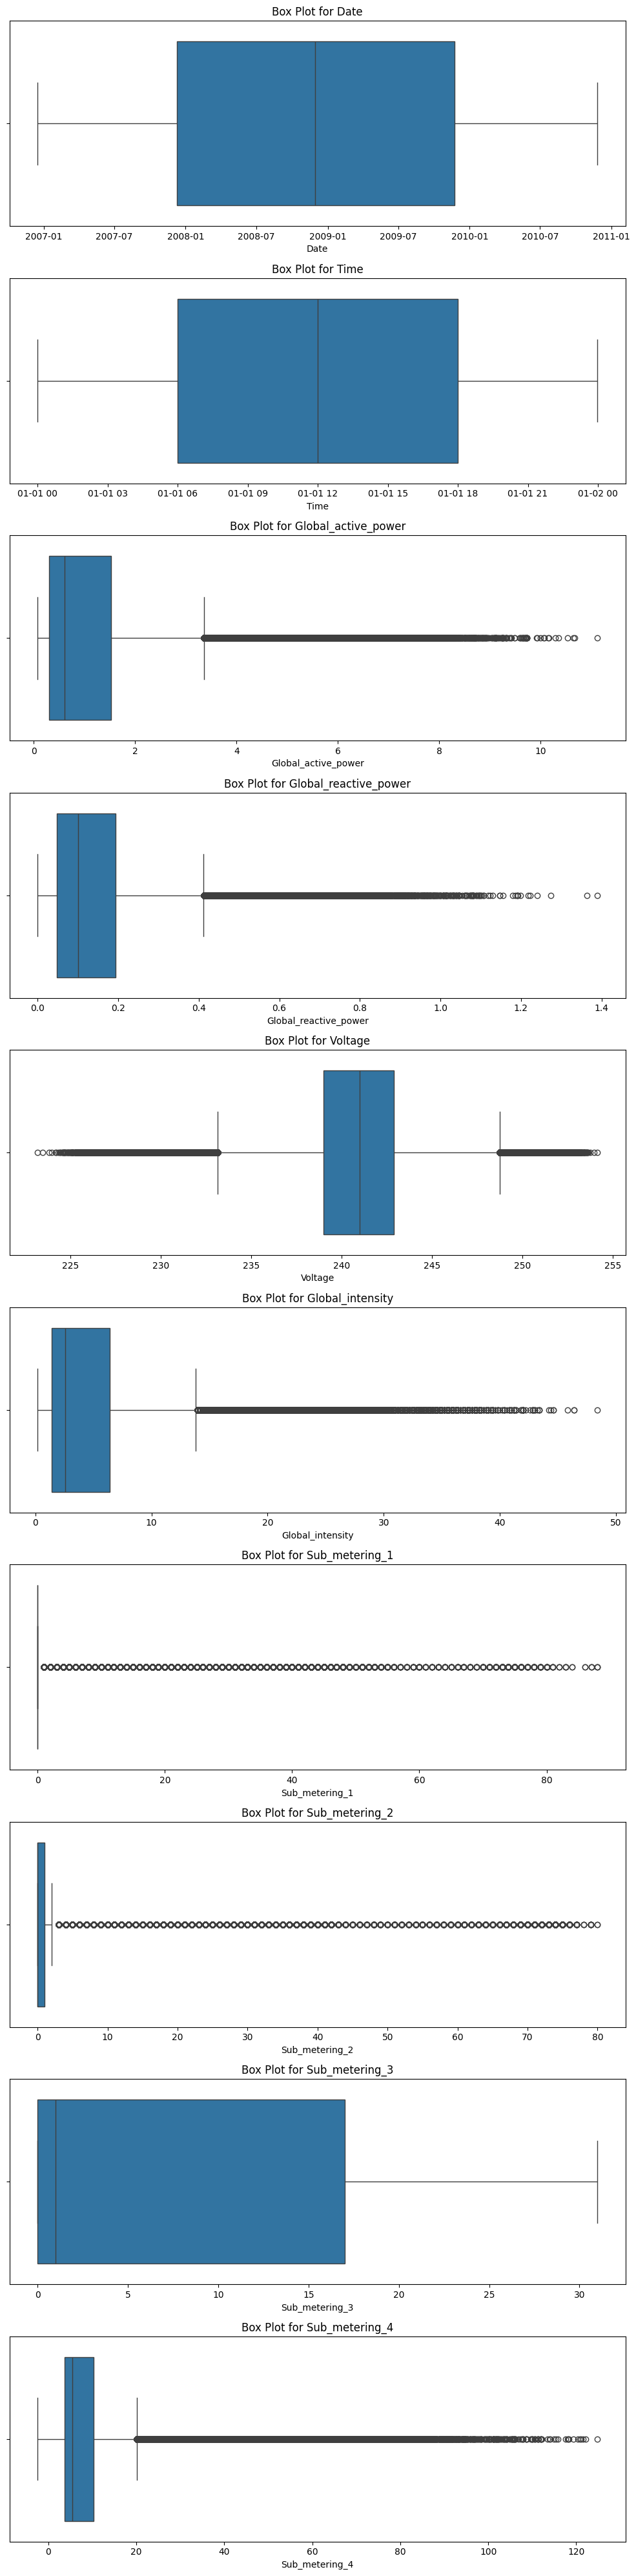

In [119]:
# Drop rows with NaN values to focus on complete cases for outlier detection
df_cleaned = df.dropna()

# Plotting box plots for each column
num_columns = df_cleaned.shape[1]
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, num_columns * 4))

for i, column in enumerate(df_cleaned.columns):
    sns.boxplot(x=df_cleaned[column], ax=axes[i])
    axes[i].set_title(f'Box Plot for {column}')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

### Skewness Verification

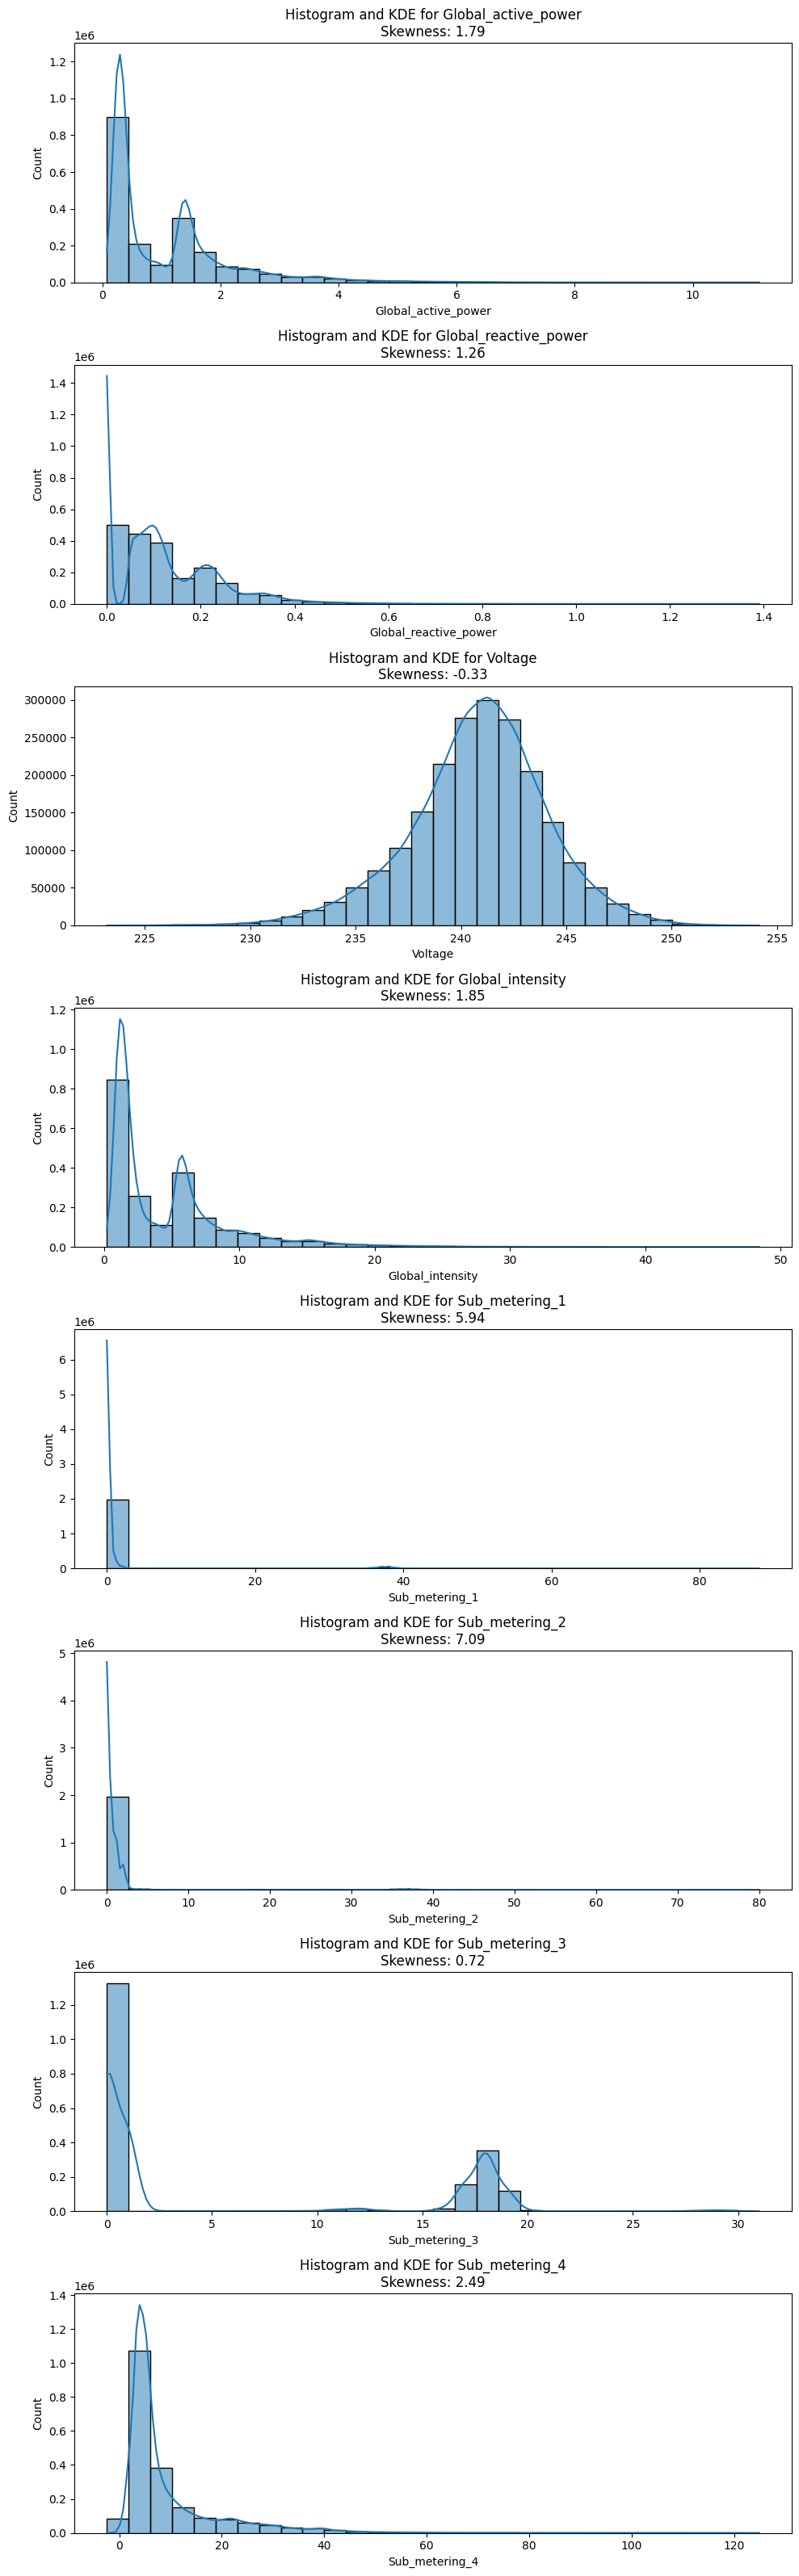

In [120]:
# Slice the DataFrame to remove the first column
dff = df.iloc[:, 2:]

# Drop rows with NaN values to clean the dataset
df_cleaned = dff.dropna()

# Calculate skewness for each numerical column
skewness = df_cleaned.skew()

# Plotting histograms for each column
num_columns = df_cleaned.shape[1]
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, num_columns * 4))

for i, column in enumerate(df_cleaned.columns):
    sns.histplot(df_cleaned[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram and KDE for {column}\nSkewness: {skewness[column]:.2f}')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()


In [121]:
dff.skew()

Global_active_power      1.786233
Global_reactive_power    1.261914
Voltage                 -0.326665
Global_intensity         1.849100
Sub_metering_1           5.944541
Sub_metering_2           7.090553
Sub_metering_3           0.724688
Sub_metering_4           2.486908
dtype: float64

### Kurtosis

In [122]:
dff.kurt() # or dff.kurtosis()

Global_active_power       4.218685
Global_reactive_power     2.605633
Voltage                   0.724707
Global_intensity          4.601243
Sub_metering_1           35.642993
Sub_metering_2           57.907344
Sub_metering_3           -1.282198
Sub_metering_4            7.910993
dtype: float64

### Handle Missing Values

Median was chosen due to the presence of Outliers & Skewness

In [123]:
# Handle missing values (fill with the median )
df.fillna(df.median(), inplace=True)

# Handle missing values (fill with the mean )
# df_ma = df.fillna(df.rolling(window=3, min_periods=1).mean())


In [124]:
#Check for missing
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Sub_metering_4           0
dtype: int64

## SID Analysis 2

### Shape

In [125]:
df.shape

(2075259, 10)

### Info

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   datetime64[ns]
 1   Time                   datetime64[ns]
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Sub_metering_4         float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 158.3 MB


### De-Stats

In [127]:
df.describe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,2075259,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,2008-12-05 19:13:27.255191040,1900-01-01 11:59:32.744808704,1.085486e+00,1.234176e-01,2.408420e+02,4.602375e+00,1.107879e+00,1.282265e+00,6.390116e+00,9.266936e+00
min,2006-12-16 00:00:00,1900-01-01 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,2007-12-12 00:00:00,1900-01-01 06:00:00,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.830000e+00
50%,2008-12-06 00:00:00,1900-01-01 12:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,2009-12-01 00:00:00,1900-01-01 18:00:00,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.023000e+01
max,2010-11-26 00:00:00,1900-01-01 23:59:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248300e+02
std,NaN,NaN,1.052065e+00,1.120452e-01,3.219699e+00,4.422241e+00,6.115669e+00,5.787271e+00,8.406114e+00,9.535166e+00


# 14-16

# Resample-Downsampling(Daily)

In [128]:
# Combine 'Date' and 'Time' columns into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Set 'DateTime' as the index and drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Set 'DateTime' as the new index
df.set_index('DateTime', inplace=True)


In [129]:
# Display the first few rows to confirm
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
DateTime,,,,,,,,
2006-12-16 17:24:00-01:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.27
2006-12-16 17:25:00-01:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.33
2006-12-16 17:26:00-01:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.57
2006-12-16 17:27:00-01:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.80
2006-12-16 17:28:00-01:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.10


In [130]:
# Resample the data to daily frequency & Using the daily sampling rate (sum)
daily_df = df.resample('D').sum()

In [131]:
# Preview head
daily_df.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
DateTime,,,,,,,,
2006-12-16 00:00:00-01:00,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.94
2006-12-17 00:00:00-01:00,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.72


# Data Split

In [132]:
# Calculate the length of the dataset
x = len(daily_df)

# Split the dataset
train_set = daily_df.iloc[:x-300]
test_set = daily_df.iloc[x-300:]


In [133]:
train_set.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
DateTime,,,,,,,,
2006-12-16 00:00:00-01:00,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.94
2006-12-17 00:00:00-01:00,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.72
2006-12-18 00:00:00-01:00,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.50
2006-12-19 00:00:00-01:00,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.82
2006-12-20 00:00:00-01:00,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.75


In [134]:
# Confirm the shapes of train and test sets
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)


Train set shape: (1142, 8)
Test set shape: (300, 8)


## Index Reset

In [135]:
# Reset index to have 'ds' column for Prophet
train_set.reset_index(inplace=True)
test_set.reset_index(inplace=True)

## Column Rename 2 Prophet Style

In [136]:
# Step 6: Prepare the data for Prophet
train_prophet = train_set.rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})
test_prophet = test_set.rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'})

In [137]:
train_prophet.head(2)

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
0,2006-12-16 00:00:00-01:00,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.94
1,2006-12-17 00:00:00-01:00,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.72


## Split TZ from DT

Split Time Zone From Date Time

In [138]:
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)
test_prophet['ds'] = test_prophet['ds'].dt.tz_localize(None)


## Initiate & Fit

In [139]:
# Step 8: Train the Prophet model
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/69t9tu77.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/129xe5ei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56980', 'data', 'file=/tmp/tmp_hvzsijd/69t9tu77.json', 'init=/tmp/tmp_hvzsijd/129xe5ei.json', 'output', 'file=/tmp/tmp_hvzsijd/prophet_modelk5lsnk43/prophet_model-20240617133707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:37:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecast/Prediction

In [141]:
# Make future dataframe for predictions
future = model.make_future_dataframe(periods=300)

# Make predictions
forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2006-12-16,2364.372011,1775.572762,2931.862377
1,2006-12-17,2357.085460,1790.748937,2959.986596
2,2006-12-18,1998.036028,1470.003514,2542.433462
3,2006-12-19,2152.577045,1583.456199,2680.703554
4,2006-12-20,2167.630508,1590.142616,2718.602546
...,...,...,...,...
1437,2010-11-22,1865.457207,1256.314563,2422.809406
1438,2010-11-23,2008.843913,1438.256844,2562.278180
1439,2010-11-24,2009.398432,1478.818161,2588.015460
1440,2010-11-25,1846.848770,1315.440280,2391.331666


## Forecast Plot

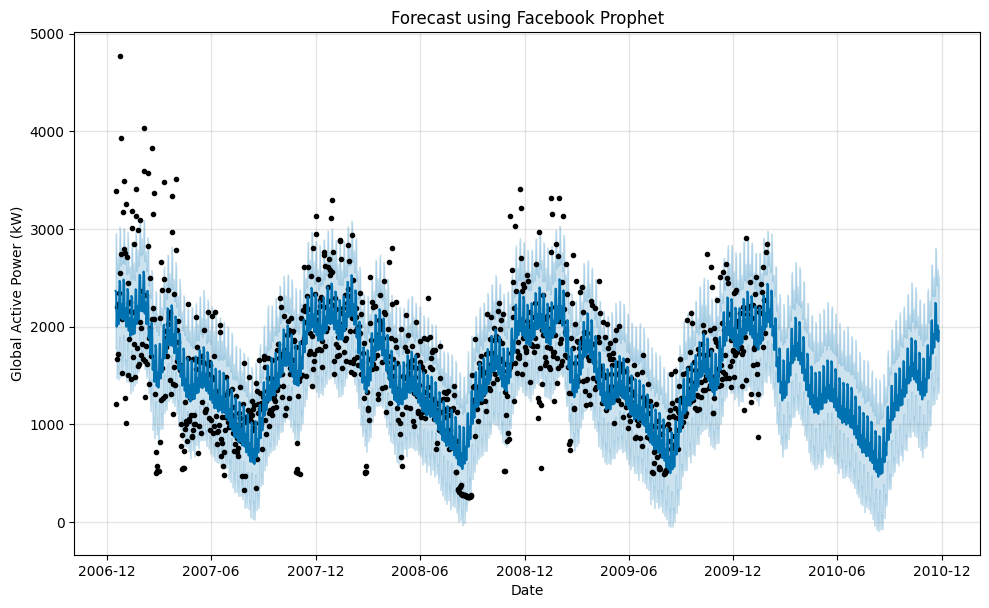

In [142]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast using Facebook Prophet')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

## Actual Vs Forecast Plot

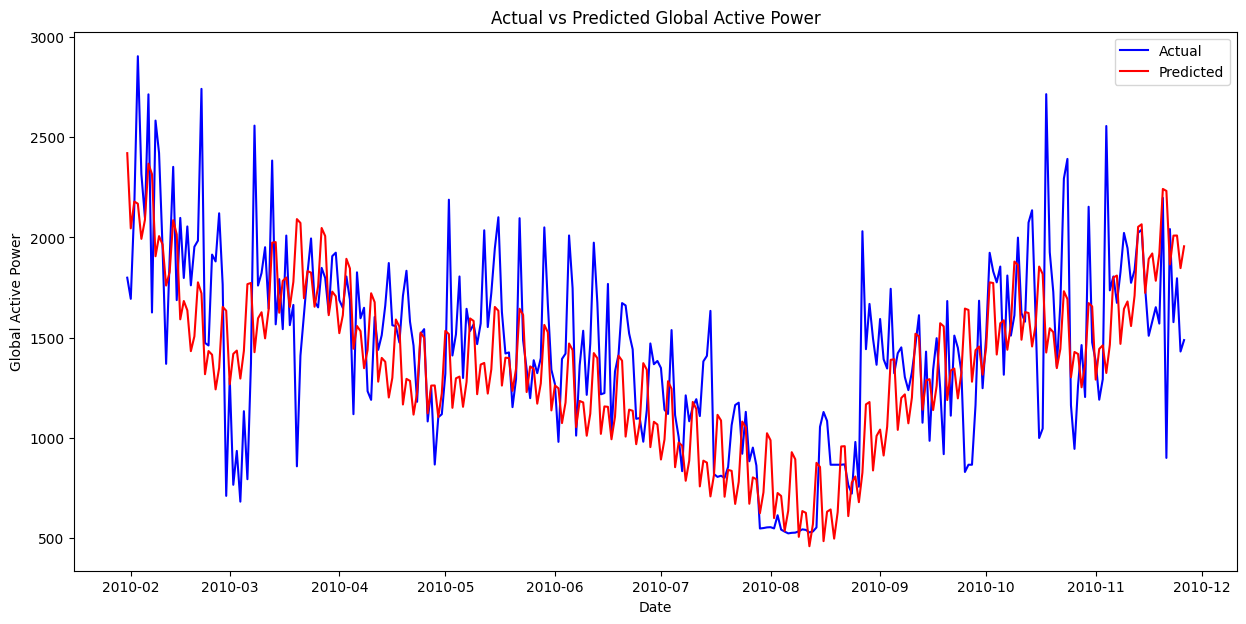

In [143]:
# Extract the predicted values for the test period
forecast_test = forecast[forecast['ds'].isin(test_prophet['ds'])]

# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.show()

## Model Evaluation

Mean Absolute Error (MAE): 286.14
Mean Squared Error (MSE): 143512.63
Root Mean Squared Error (RMSE): 378.83
Mean Absolute Percentage Error (MAPE): 0.21
R-squared (R2): 0.34


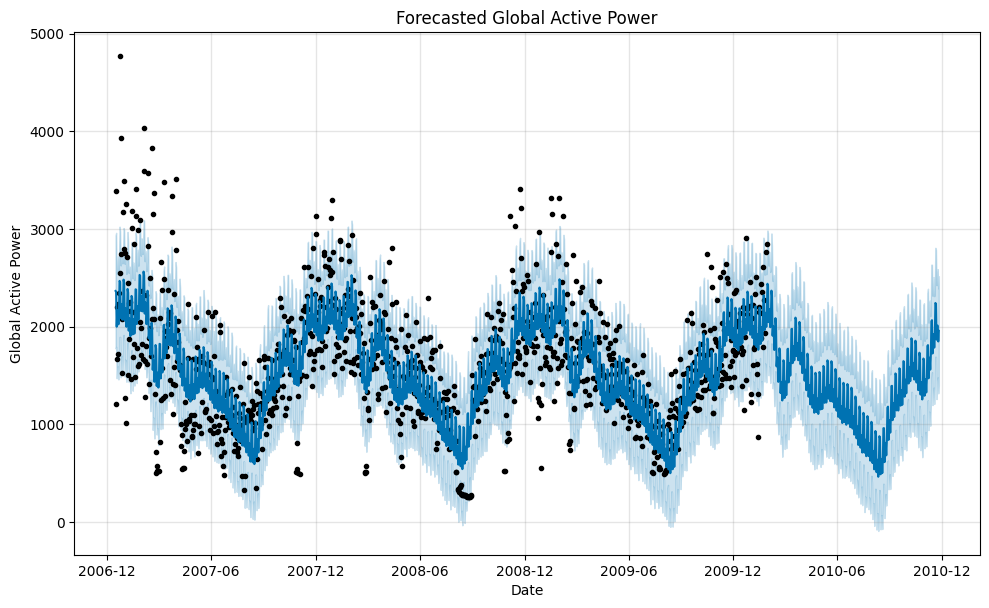

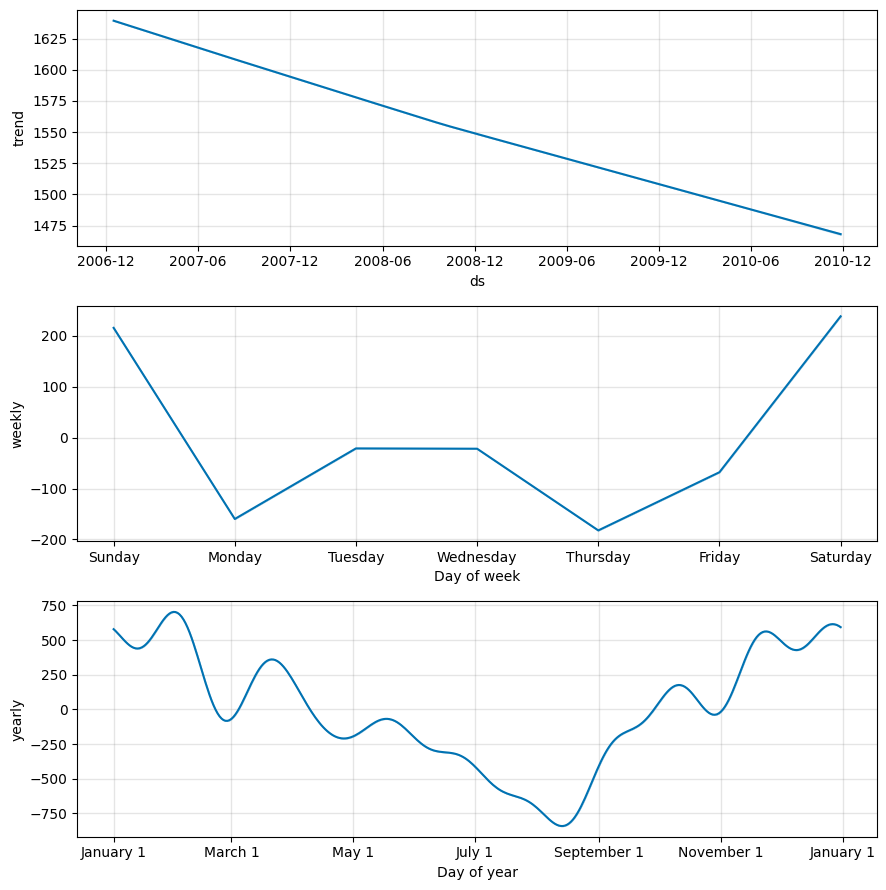

In [144]:
# Calculate evaluation metrics
mae = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
mse = mean_squared_error(test_prophet['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_prophet['y'], forecast_test['yhat'])
r2 = r2_score(test_prophet['y'], forecast_test['yhat'])

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')
print(f'R-squared (R2): {r2:.2f}')


# Model Summary
model.plot(forecast)
plt.title('Forecasted Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

model.plot_components(forecast)
plt.show()


# 17-20

## MRs

In [149]:
# List of regressors
regressors = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Ensure the regressors are included in the train and test sets
for reg in regressors:
    train_prophet[reg] = train_set[reg].values
    test_prophet[reg] = test_set[reg].values


## Model Training

In [150]:
# Initialize the Prophet model
model = Prophet()

# Add the regressors to the model
for reg in regressors:
    model.add_regressor(reg)


In [151]:
# Train the model with the training data
model.fit(train_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/4qcxu1af.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/6zjn70aj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=199', 'data', 'file=/tmp/tmp_hvzsijd/4qcxu1af.json', 'init=/tmp/tmp_hvzsijd/6zjn70aj.json', 'output', 'file=/tmp/tmp_hvzsijd/prophet_model1k1pfgt3/prophet_model-20240617134950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:49:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Prediciton

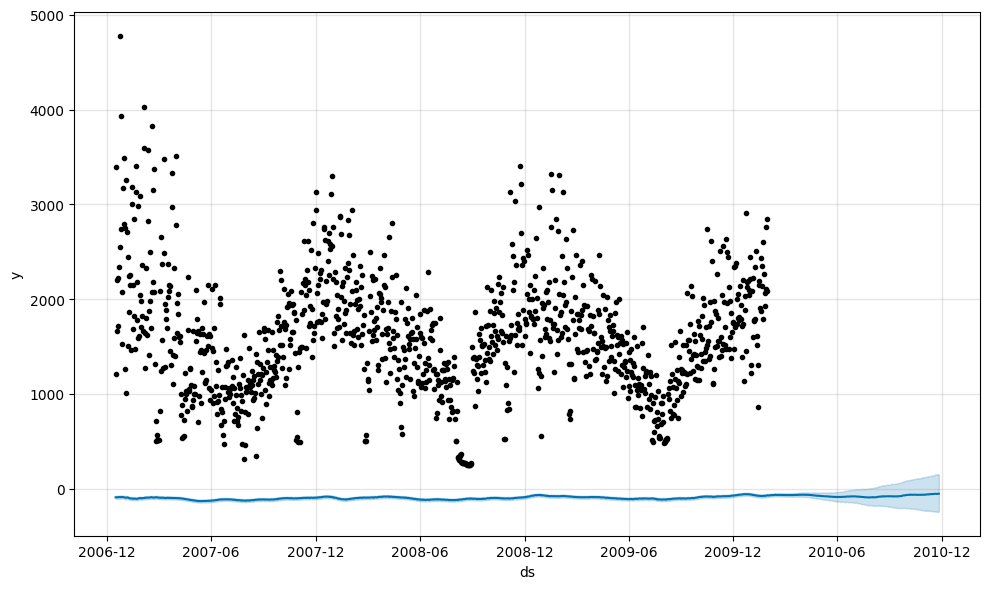

In [152]:
# Create a future dataframe for predictions, including the historical period
future = model.make_future_dataframe(periods=300)

# Append the regressors' historical data and future periods
for reg in regressors:
    future[reg] = pd.concat([df[reg], pd.Series([None]*300)], ignore_index=True)

# Make predictions
forecast2 = model.predict(future)

# Display the forecast
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Optionally, you can plot the forecast
fig = model.plot(forecast2)


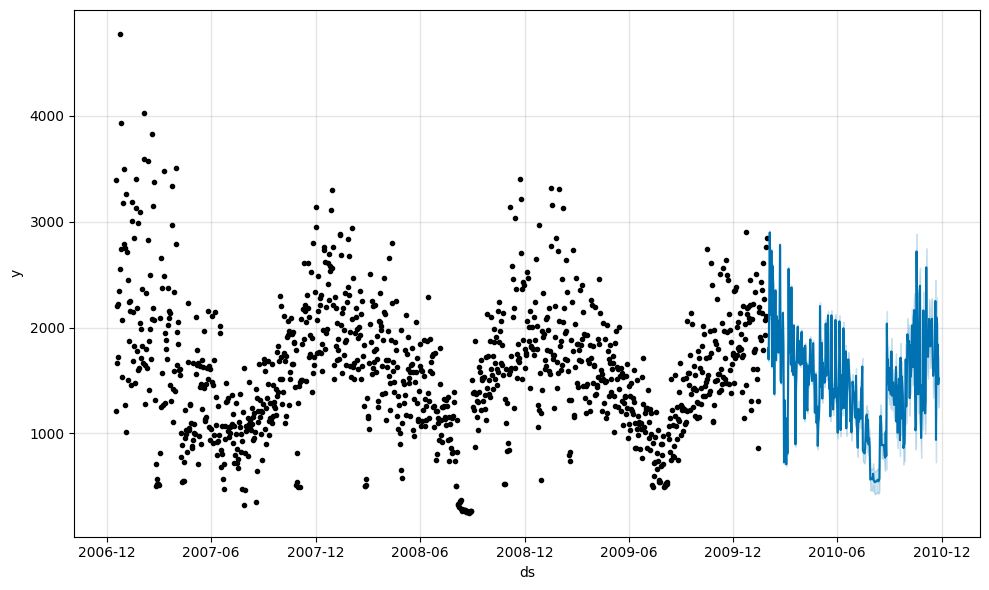

In [153]:
# Make predictions for the test set
forecast2 = model.predict(test_prophet)

# Plot the results
fig = model.plot(forecast2)
plt.show()


In [154]:
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-31,1803.125928,1787.778871,1819.804936
1,2010-02-01,1698.452159,1681.431021,1713.797715
2,2010-02-02,2150.978682,2135.116909,2167.086603
3,2010-02-03,2898.164672,2882.456815,2915.643530
4,2010-02-04,2322.510112,2307.343933,2339.135363
...,...,...,...,...
295,2010-11-22,2093.335254,1875.744145,2288.351932
296,2010-11-23,1634.435616,1418.194040,1833.110577
297,2010-11-24,1841.320377,1623.062204,2049.308785
298,2010-11-25,1464.224066,1244.248211,1677.636794


## Model Component

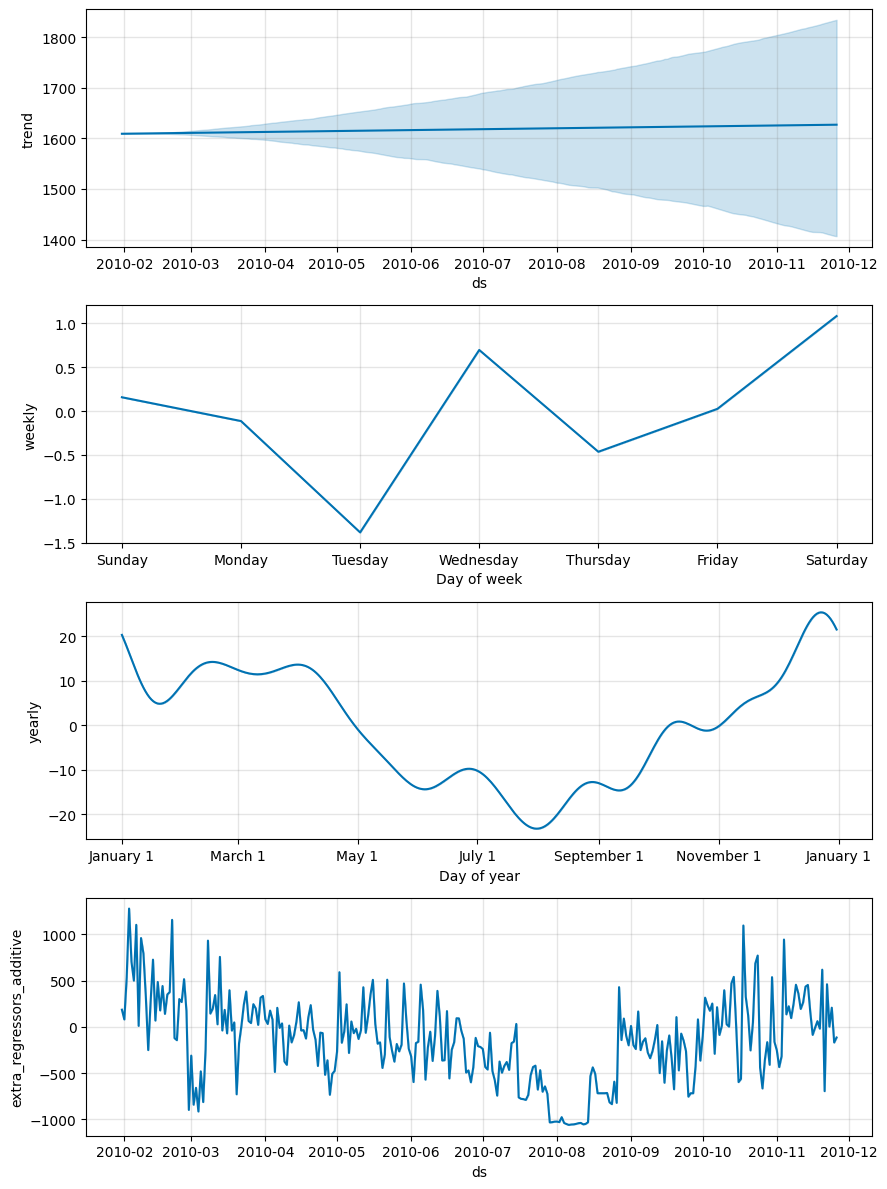

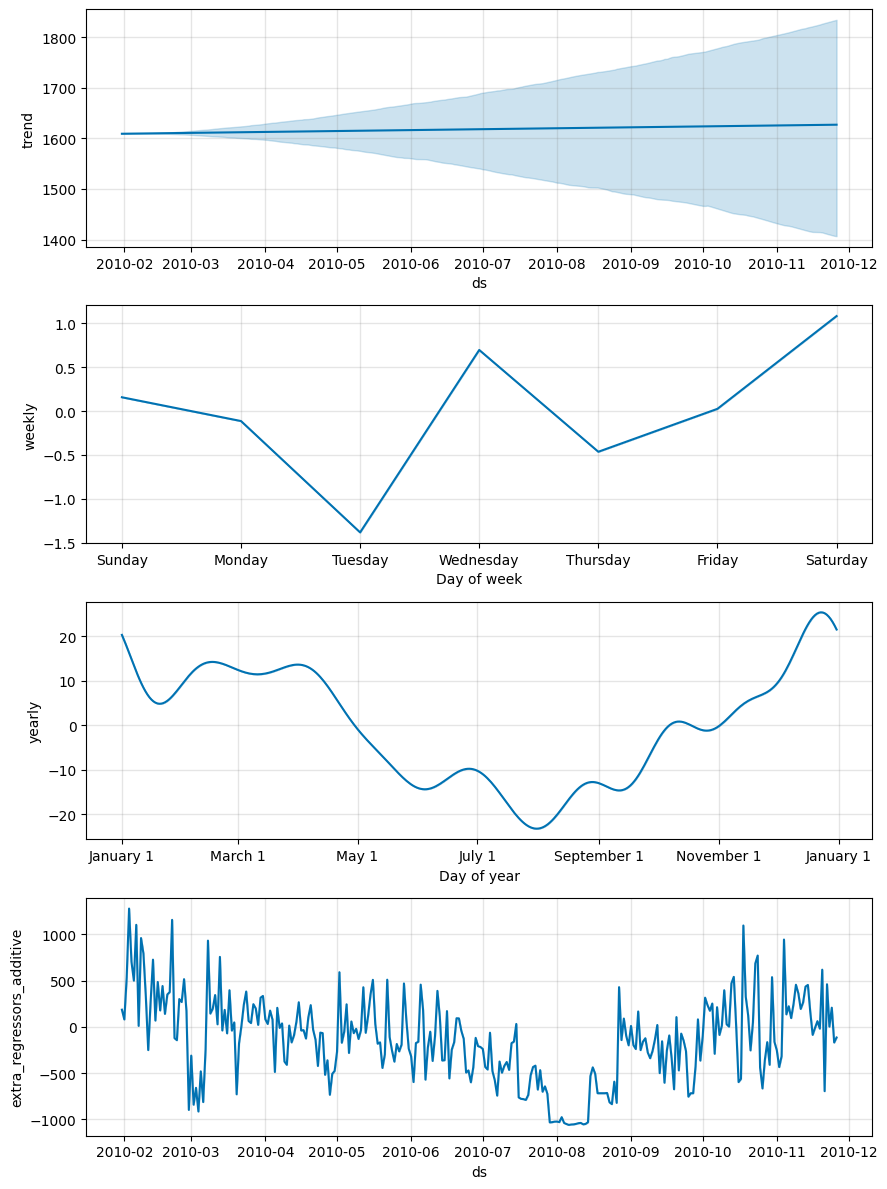

In [155]:
model.plot_components(forecast2)


## Evaluation

In [156]:
# Calculate evaluation metrics
mae = mean_absolute_error(test_prophet['y'], forecast['yhat'][-300:])
mse = mean_squared_error(test_prophet['y'], forecast['yhat'][-300:])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_prophet['y'] - forecast['yhat'][-300:]) / test_prophet['y'])) * 100
r2 = r2_score(test_prophet['y'], forecast['yhat'][-300:])

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R2): {r2:.2f}')


Mean Absolute Error (MAE): 286.14
Mean Squared Error (MSE): 143512.63
Root Mean Squared Error (RMSE): 378.83
Mean Absolute Percentage Error (MAPE): nan%
R-squared (R2): 0.34


In [158]:
# Align the indices
aligned_test_y = test_prophet['y'].reset_index(drop=True)
aligned_forecast_yhat = forecast['yhat'][-300:].reset_index(drop=True)

# Create a boolean mask for non-zero values
non_zero_mask = aligned_test_y != 0

# Filter out zero values
filtered_y_true = aligned_test_y[non_zero_mask]
filtered_y_pred = aligned_forecast_yhat[non_zero_mask]

# Calculate evaluation metrics
mae = mean_absolute_error(filtered_y_true, filtered_y_pred)
mse = mean_squared_error(filtered_y_true, filtered_y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((filtered_y_true - filtered_y_pred) / filtered_y_true)) * 100
r2 = r2_score(filtered_y_true, filtered_y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R2): {r2:.2f}')


Mean Absolute Error (MAE): 286.14
Mean Squared Error (MSE): 143512.63
Root Mean Squared Error (RMSE): 378.83
Mean Absolute Percentage Error (MAPE): 21.40%
R-squared (R2): 0.34


## Cross Validation

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/p51c66mk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/2xgp75oq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5598', 'data', 'file=/tmp/tmp_hvzsijd/p51c66mk.json', 'init=/tmp/tmp_hvzsijd/2xgp75oq.json', 'output', 'file=/tmp/tmp_hvzsijd/prophet_modelmzkkrxw6/prophet_model-20240617140558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2009-01-30 00:00:00 and 2009-01-30 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/_bh9lt96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_hvzsijd/302t890g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28239', 'data', 'file=/tmp/tmp_hvzsijd/_bh9lt96.json', 'init=/tmp/tmp_hvzsijd/302t890g.json', 'output', 'file=/tmp/tmp_hvzsijd/prophet_modelxgsx2p3h/prophet_model-20240617140559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


     horizon        mae          mse       rmse      mape  coverage
0    36 days  32.145452  1417.387582  37.648208  0.020544  0.250000
1    37 days  32.886514  1448.030885  38.053001  0.020884  0.222222
2    38 days  33.802664  1500.768010  38.739747  0.021443  0.194444
3    39 days  35.198551  1575.241296  39.689310  0.022200  0.166667
4    40 days  36.529412  1642.286293  40.525132  0.022749  0.138889
..       ...        ...          ...        ...       ...       ...
325 361 days  82.161602  6950.372682  83.368895  0.045116  1.000000
326 362 days  82.784555  7049.620915  83.962021  0.045023  1.000000
327 363 days  82.907105  7068.143373  84.072251  0.044647  1.000000
328 364 days  83.948362  7183.231636  84.753948  0.045280  1.000000
329 365 days  84.672216  7312.787614  85.514839  0.045283  1.000000

[330 rows x 6 columns]


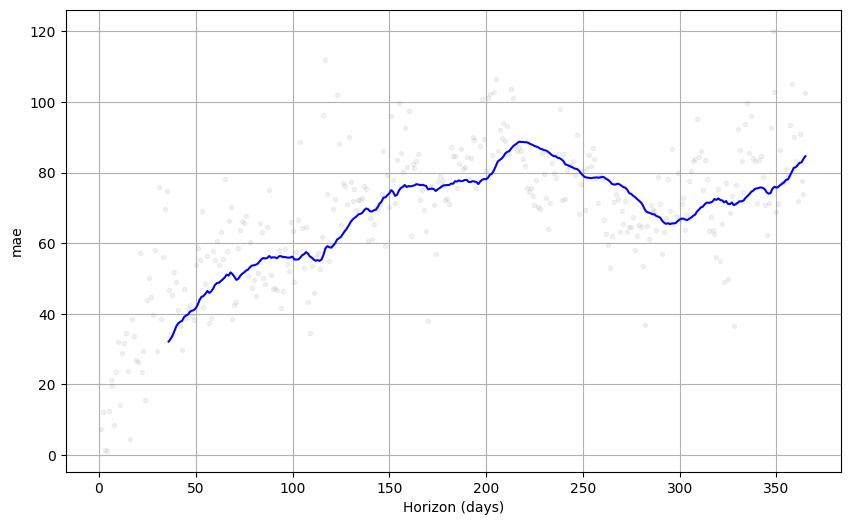

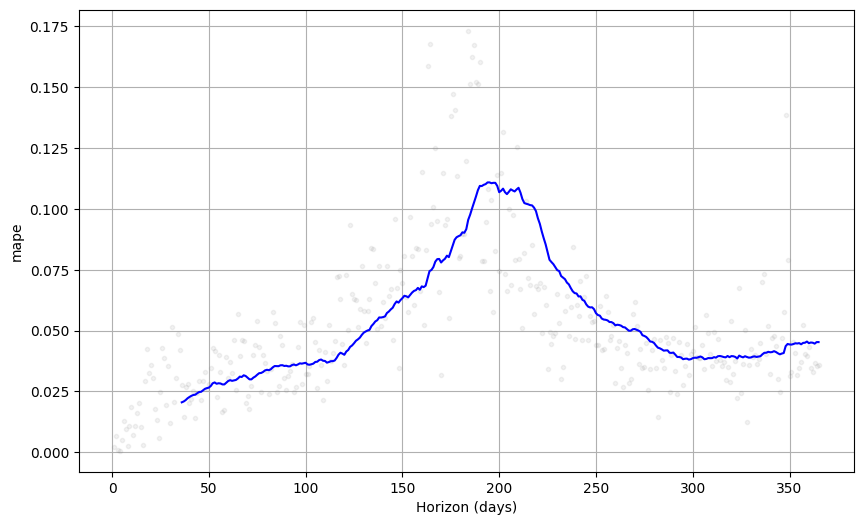

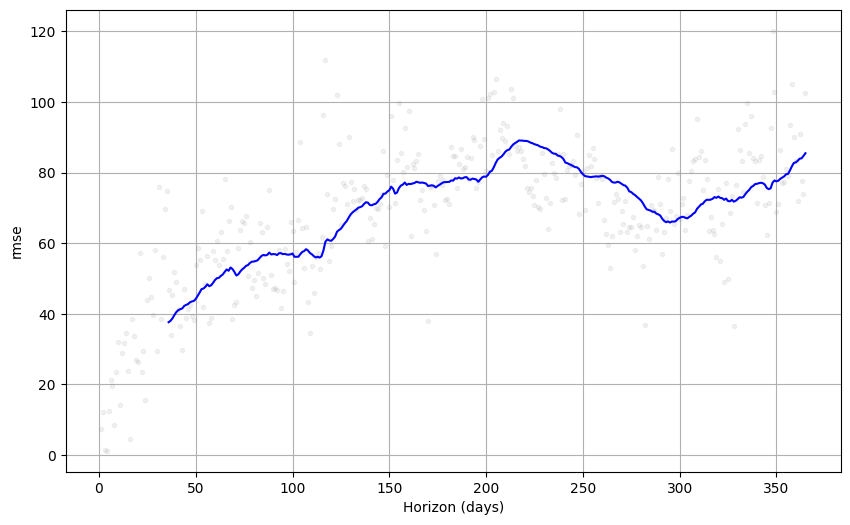

In [167]:
# Step 1: Fit the Prophet model on the training data with regressors
model = Prophet()

# Adding regressors to the Prophet model
for reg in regressors:
    model.add_regressor(reg)

# Fit the model with the training set
model.fit(train_prophet)

# Step 2: Define the cross-validation configuration
# initial: Initial training period, horizon: forecasting period, period: cutoff spacing
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Step 3: Calculate performance metrics
df_performance = performance_metrics(df_cv)

# Display the performance metrics
print(df_performance[['horizon', 'mae', 'mse', 'rmse', 'mape', 'coverage']])

# Step 4: Plot the cross-validation performance metrics
fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')

plt.show()
